In [14]:
#Using Google Collab so we can use the Collab Pro subcription to run the calculation faster
from google.colab import drive
drive.mount('/content/drive')
PATH = "/content/drive/My Drive/Deeplearning/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import pandas as pd

trade_raw = pd.read_csv(PATH + "/Gravity_csv_V202211/Gravity_V202211.csv")

<ipython-input-15-1d0d8b83e241>:3: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  trade_raw = pd.read_csv(PATH + "/Gravity_csv_V202211/Gravity_V202211.csv")


In [16]:
trade_raw_dropna = trade_raw.dropna(subset=['tradeflow_baci'])
print(trade_raw_dropna.head())

     year country_id_o country_id_d iso3_o iso3_d  iso3num_o  iso3num_d  \
143  2017          ABW          AFG    ABW    AFG      533.0        4.0   
144  2018          ABW          AFG    ABW    AFG      533.0        4.0   
145  2019          ABW          AFG    ABW    AFG      533.0        4.0   
207  2007          ABW          AGO    ABW    AGO      533.0       24.0   
209  2009          ABW          AGO    ABW    AGO      533.0       24.0   

     country_exists_o  country_exists_d  gmt_offset_2020_o  ...  entry_time_o  \
143                 1                 1               -4.0  ...           NaN   
144                 1                 1               -4.0  ...           NaN   
145                 1                 1               -4.0  ...           NaN   
207                 1                 1               -4.0  ...           NaN   
209                 1                 1               -4.0  ...           NaN   

     entry_time_d  entry_tp_o  entry_tp_d  tradeflow_comtrade_

creating onyl one pair of country by meaning their past trade

In [17]:
trade_data  = trade_raw_dropna.groupby(['iso3_o', 'iso3_d'])['tradeflow_baci'].mean().reset_index()

In [18]:
trade_data  = trade_data.rename(columns={
    'iso3_o': 'exporter',
    'iso3_d': 'importer',
    'tradeflow_baci': 'trade_usd'
})

In [19]:
print(trade_data.head())

  exporter importer     trade_usd
0      ABW      AFG    541.454333
1      ABW      AGO   6293.863375
2      ABW      ALB     15.218000
3      ABW      AND      1.174000
4      ABW      ANT  22732.622286


load news

In [20]:
news = pd.read_csv(PATH + "Output/paired_countries_with_sentiment.csv")

In [21]:
print(news.head())

         date                                          Headlines  \
0  2018-01-10  Cramer makes the bull case for China's move to...   
1  2018-03-20  Cambridge Analytica played key Trump campaign ...   
2  2018-03-20  Amazon is now second most valuable U.S.-listed...   
3  2018-03-20  New Zealand court rejects Megaupload founder's...   
4  2018-03-20  France's Le Maire blames 'unfair trade' for gl...   

                                         Description   source country_pair  \
0  Jim Cramer laid out the benefits of China pote...     CNBC      CHN-USA   
1  The suspended chief executive of UK-based poli...  Reuters      GBR-USA   
2  Amazon.com became the second most valuable pub...  Reuters      JPN-USA   
3  A New Zealand court rejected on Wednesday inte...  Reuters      NZL-USA   
4  Unfair trade and an overproduction of steel ar...  Reuters      ARG-FRA   

  sentiment_label  sentiment_score  
0        positive         0.962832  
1         neutral         0.996708  
2        po

In [22]:
# Normalize trade: 0–1 scale across all rows
trade_data["trade_weight"] = (trade_data["trade_usd"] - trade_data["trade_usd"].min()) / (
     trade_data["trade_usd"].max() - trade_data["trade_usd"].min())
trade_data = trade_data[["exporter", "importer", "trade_weight"]]


In [23]:
# 3.  Persist for transparency
trade_path = PATH + "Output/trade_weights_2019.csv"
trade_data.to_csv(trade_path, index=False)
print("✅  Trade weight table saved to:", trade_path)
trade_data.head()

✅  Trade weight table saved to: /content/drive/My Drive/Deeplearning/Output/trade_weights_2019.csv


,exporter,importer,trade_weight
0,ABW,AFG,2.048850e-06
1,ABW,AGO,2.381587e-05
2,ABW,ALB,5.758087e-08
3,ABW,AND,4.438612e-09
4,ABW,ANT,8.601985e-05


Aggregate to week‑level metrics

In [24]:
import numpy as np
import pandas as pd

# 0.  Load the sentiment-enriched file
pairs_path = PATH + "Output/paired_countries_with_sentiment.csv"
df = pd.read_csv(pairs_path, parse_dates=["date"])

# 1.  Prep helper columns
df["is_neg"] = df["sentiment_label"].str.lower().eq("negative")
# Handle NaT values in 'date' column before applying to_period
df["week"] = df["date"].dt.to_period("W")
df.loc[df["week"].isnull(), "week"] = pd.NaT
df["week"] = df["week"].apply(lambda x: x.start_time if pd.notnull(x) else pd.NaT)

In [25]:
# 2.  Aggregate to week × pair
agg = (
    df.groupby(["week", "country_pair"])
      .agg(
          n_articles=("Headlines", "size"),
          n_neg     =("is_neg", "sum"),
      )
      .reset_index()
)
agg["neg_share"]       = agg["n_neg"] / agg["n_articles"]
agg["media_attention"] = np.log1p(agg["n_articles"])

In [26]:
# 3.  Split pair into two ISO-3 codes for the trade merge
agg[["c1", "c2"]] = agg["country_pair"].str.split("-", expand=True)

# 4.  Merge trade weights (directional)
trade_df = pd.read_csv(trade_path)          # from Cell 19
agg = agg.merge(
    trade_df,
    left_on = ["c1", "c2"],
    right_on = ["exporter", "importer"],
    how="left"
).fillna({"trade_weight": 0})

In [27]:
# 5.  Compute raw score
agg["conflict_score"] = (
    agg["neg_share"] * agg["media_attention"] * agg["trade_weight"]
)

In [31]:
# 7.  Save the result
score_path = PATH + "Output/conflict_scores_weekly.csv"
agg.to_csv(score_path, index=False)
print("✅  Weekly Conflict-Score saved to:", score_path)
agg.head()


✅  Weekly Conflict-Score saved to: /content/drive/My Drive/Deeplearning/Output/conflict_scores_weekly.csv


,week,country_pair,n_articles,n_neg,neg_share,media_attention,c1,c2,exporter,importer,trade_weight,conflict_score
0,2018-01-08,CHN-USA,1,0,0.0,0.693147,CHN,USA,CHN,USA,0.980183,0.000000
1,2018-03-19,ARG-FRA,1,0,0.0,0.693147,ARG,FRA,ARG,FRA,0.001745,0.000000
2,2018-03-19,BEL-IRL,1,0,0.0,0.693147,BEL,IRL,BEL,IRL,0.006636,0.000000
3,2018-03-19,BRA-GBR,1,1,1.0,0.693147,BRA,GBR,BRA,GBR,0.011363,0.007877
4,2018-03-19,CAN-USA,2,0,0.0,1.098612,CAN,USA,CAN,USA,1.000000,0.000000


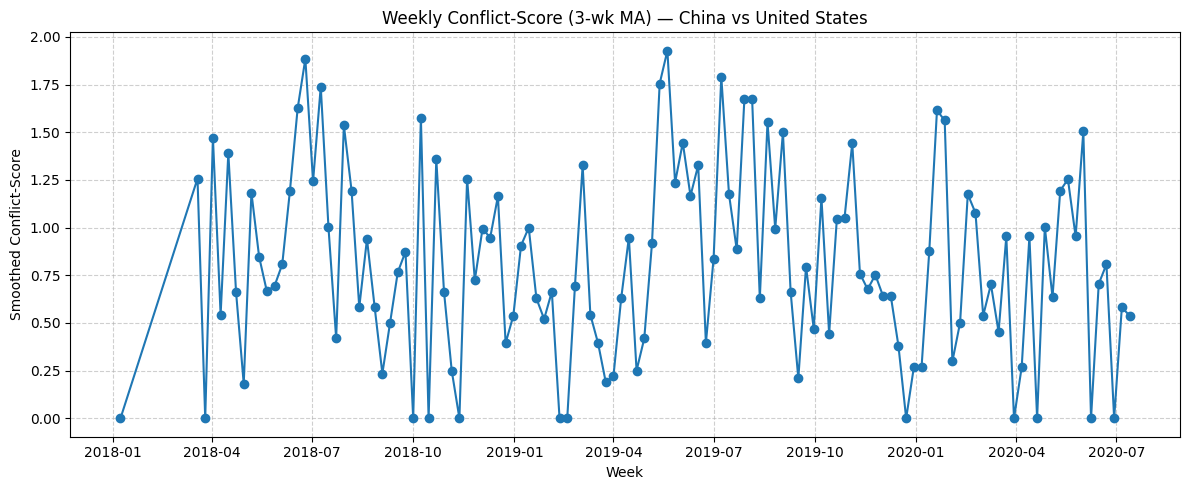

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# 1.  Load the weekly score file we just created
scores = pd.read_csv(PATH + "Output/conflict_scores_weekly.csv", parse_dates=["week"])

# 2.  Canonical pair code is alphabetical (CHN-USA)
pair = "-".join(sorted(["CHN", "USA"]))      # → "CHN-USA"

df_pair = (
    scores[scores["country_pair"] == pair]
      .sort_values("week")
)

if df_pair.empty:
    raise ValueError(f"No rows found for pair {pair}. Check country codes.")

# 3.  Plot the smoothed score over time
plt.figure(figsize=(12, 5))
plt.plot(df_pair["week"], df_pair["conflict_score"], marker="o")
plt.title("Weekly Conflict-Score (3-wk MA) — China vs United States")
plt.xlabel("Week")
plt.ylabel("Smoothed Conflict-Score")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
